# Summary

Use this notebook to generate training data.
- (i) initialize an observer (with or without parallax)
- (ii) randomly sample sources and lenses relative to one another
- (iii) observe the source $N_O$ times, creating a list of celestial coordinates, $[\phi, \theta]_i$.
- (iv) repeat this process $N_t$ times

# Downloads

In [1]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload

import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm

# Astropy
from astropy import units as u

# lenstools
import lenstools as lt

# Convenient variables
pi   = np.pi
norm = np.linalg.norm
mult = np.matmul
dot  = np.dot

# Parameters

In [3]:
# Don't use Astopy units, for a speedup
units = False

# Training set size
N_t = int(1e5)

In [4]:
# Observer properties

# Number of observations
N_o = 20

# Observation time
t_obs = 5
if units:
    t_obs *= u.yr

# Time increment for observations
dt = t_obs/N_o

# Flag to include parallax or not
#    observer moves along a cirlce of radius 1AU with period 1yr
parallax = True

In [5]:
# Lens properties

# mass parameter of lenses in M_sol
M_l = 1e7

# kind of lens: ['point', 'Gaussian', 'tNFW', 'Burkert']
# Warning: Latter two not implemented yet
kind = 'Gaussian'

# Length scale of lens mass distribution in kpc
R_l = 1e-3

# Length scale of observer-lens distance in kpc
D_ol = 1.

if units:
    M_l *= u.M_sun
    R_l *= u.kpc
    D_ol *= u.kpc

In [6]:
# Source properties

# Length scale of lens-source distance
D_ls = 1.

# Length scale of source impact parameter
D_b = 1.

if units:
    D_ls *= u.kpc
    D_b *= u.kpc

In [7]:
# length scales will be used according to:
#    scale[0] -> uniform distribution of lens distance from observer
#    scale[1] -> uniform distribution of source distance past lens
#    scale[2] -> uniform distribution of source perp distance from 
#                observer-lens axis

scale = [D_ol, D_ls, D_b]

# Example: Lucky Event

Use a reference frame where $z$ is up-down, $x$ is left-right, and $y$ is distance in front or behind. 

So an object straight in front of you (the observer) has only a non-zero $y$ coordinate, and angular coordinates $\theta = \phi = \pi/2$, and $\phi$ will shrink if $x$ grows.

In [8]:
%autoreload
# Create an observer object
obs = lt.Observer(parallax = parallax, units=units)

# Create a Lens that is ~.1 kpc away (in the y-direction), moves
# very fast along the x-axis, and transits over the span of ~5 yrs
lucky_lens = lt.Lens(
    x = np.array([-.05, 100, 0]) * 1e-3,  # in kpc
    v = np.array([2e4, 0, 0]) * (u.km/u.s).to(u.kpc/u.yr),  # in km/s
    kind=kind, M=M_l, R=R_l
) 

# The source is stationary, in the z-y plane, and has a small
# impact parameter (is slightly above the x-y plane)
lucky_src = lt.Source(
    x = np.array([0, 300, 10]) * 1e-3,  # in pc
    v = np.array([0, 0, 0]) * (u.km/u.s).to(u.kpc/u.yr)  # in km/s
)

if units:
    lucky_lens.x *= u.kpc
    lucky_src.x *= u.kpc
    
    lucky_lens.v *= u.kpc/u.yr
    lucky_src.v *= u.kpc/u.yr

In [9]:
# Observe the source without any lensing
res_unlensed = obs.observe(lucky_src)

# Observe the source with lensing
res_lensed = obs.observe(lucky_src, lucky_lens)

# Compare lensed and unlensed observations
if units:
    print('[d\\theta, d\phi]:', (res_lensed-res_unlensed).to(u.mas))
else:
    print('[d\\theta, d\phi]:', (res_lensed-res_unlensed) * u.rad.to(u.mas) * 1e3) 

[d\theta, d\phi]: [-26286.53385684   -394.77436551]


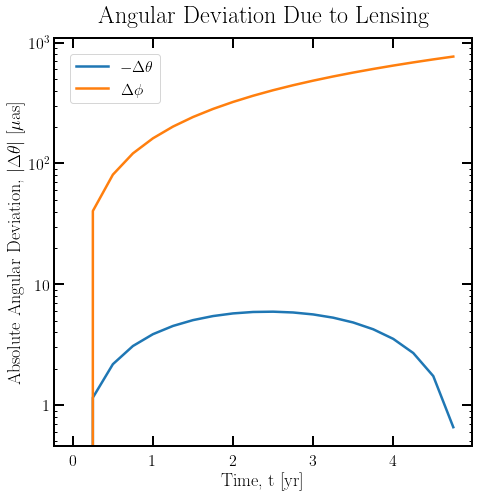

In [10]:
%autoreload
# Now observe multiple times
# Multi-measurements are defined such that \theta_0 and \phi_0
# are subtracted from the list of measurements
# The deviations between lensed/unlensed becomes smaller as a result

res_unlensed = obs.observe(lucky_src, N=N_o, dt=dt)
res_lensed = obs.observe(lucky_src, lucky_lens, N=N_o, dt=dt)

plt.figure(figsize=(7.5,7.5))
# plt.loglog()
plt.yscale('log')

if units:
    times = np.arange(0, t_obs.value, dt.value) * dt.unit
    res = np.array(res_lensed-res_unlensed)
    
else:
    times = np.arange(0, t_obs, dt)
    res = np.array(res_lensed-res_unlensed) * lt.rad_to_muas * 1e-3
    
plt.plot(times, -res[:,0]*1e3, label=r'$-\Delta \theta$')
plt.plot(times, res[:,1]*1e3, label=r'$\Delta \phi$')

plt.xlabel('Time, t [yr]')
plt.ylabel(
    r'Absolute Angular Deviation, $|\Delta \theta |$ [$\mu$as]')
plt.title('Angular Deviation Due to Lensing')
plt.legend()

# Example 2: Random Lens and Source

In [93]:
# If you want to see more than just straight lines,
# observe over longer time intervals
N_o = 20

# Observation time
# t_obs = scale[2]/lt.v_esc
t_obs = 5
if units:
    t_obs *= u.yr
    
# Time increment for observations
dt = t_obs/N_o

Text(0.5, 1.0, 'Impact Parameter Between Source and Lens')

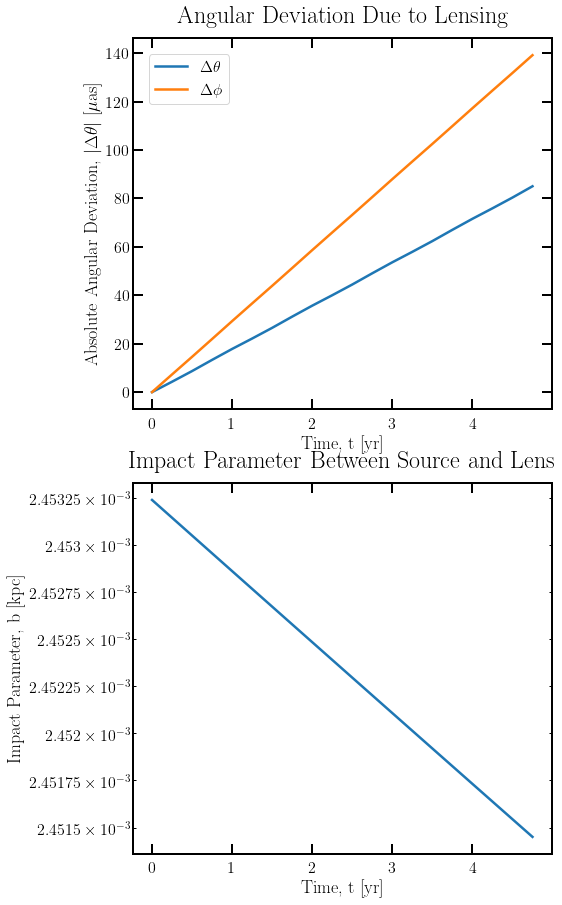

In [94]:
%autoreload

v_esc = lt.v_esc
if units:
    v_esc = v_esc * u.kpc/u.yr

# Try generating a random lens-source pair
lens, src = lt.sample(
    'relative', scale=scale, observer=obs, kind=kind, M=M_l, R=R_l, v_esc=v_esc)

res_unlensed = obs.observe(src, N=N_o, dt=dt)
res_lensed = obs.observe(src, lens, N=N_o, dt=dt)

_, axarr = plt.subplots(2, 1, figsize=(7.5, 15))
# plt.loglog()

if units:
    times = np.arange(0, t_obs.value, dt.value) * dt.unit
    res = np.array(res_lensed-res_unlensed)
    
    
    
else:
    times = np.arange(0, t_obs, dt)
    res = np.array(res_lensed-res_unlensed) * lt.rad_to_muas * 1e-3
    
axarr[0].plot(times, res[:,0]*1e3, label=r'$\Delta \theta$')
axarr[0].plot(times, res[:,1]*1e3, label=r'$\Delta \phi$')

axarr[0].set_xlabel('Time, t [yr]')
axarr[0].set_ylabel(
    r'Absolute Angular Deviation, $|\Delta \theta |$ [$\mu$as]')
axarr[0].set_title('Angular Deviation Due to Lensing')
axarr[0].legend()

axarr[1].set_yscale('log')
# axarr[1].plot(times, lt.distance(src, lens, N_o, dt))
axarr[1].plot(times, lt.distance(src, lens, N_o, dt, impact=True, observer=obs))

axarr[1].set_xlabel('Time, t [yr]')
axarr[1].set_ylabel(
    r'Impact Parameter, b [kpc]')
axarr[1].set_title('Impact Parameter Between Source and Lens')

# Generate Single-Blip Training Data

In [65]:
%autoreload
N_t = int(1e5)
N_o = 20
t_obs = 5
dt = t_obs/N_o

In [66]:
%%prun

# Set the impact parameter scale to something smaller to get 
# more of a signal
scale[2] = 10*1e-3
if units:
    scale[2] *= u.kpc

scale2 = [s for s in scale]

v_esc = lt.v_esc
if units:
    v_esc = v_esc * u.kpc/u.yr
    
# lenses = lt.Lenses()
# sources = lt.Sources()

# # Progress bar
# for i in tqdm(np.arange(N_t)):
#     lens, src = lt.sample(
#         'relative', scale=scale, observer=obs,
#         kind=kind, M=M_l, R=R_l, v_esc=v_esc
#     )
    
#     lenses.append(lens)
#     sources.append(src)
    
#     res_unlensed = obs.observe(src, N=N_o, dt=dt)
#     res_lensed = obs.observe(src, lens, N=N_o, dt=dt)

#     Tset[i] = np.array(res_lensed-res_unlensed)

def inv_cdf(p):
    return p

lenses, sources = lt.sample('standard', N_t, scale,
                            inv_cdf, obs, kind, M_l, R_l, 1, v_esc)

Tset = (
    obs.observe(sources, lenses, N=N_o, dt=dt)  # Lensed images
    - obs.observe(sources, N=N_o, dt=dt)  # Unlensed images
) * lt.rad_to_muas

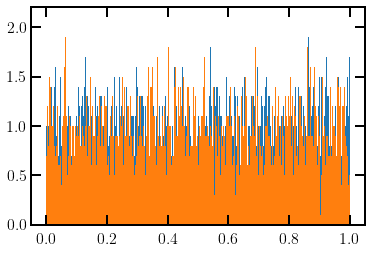

In [489]:
n = (lenses.x - obs.x) / lt.multinorm(lenses.x - obs.x)[:, np.newaxis]

histo(lt.multinorm(lenses.x - obs.x))
histo(np.sum((sources.x - lenses.x) * n, axis=1))

In [579]:
print(
    np.mean(Tset[:,-1,0]), np.std(Tset[:,-1,0])/np.sqrt(N_t), '\n',
    np.mean(Tset[:,-1,1]), np.std(Tset[:,-1,1])/np.sqrt(N_t)
)

1.0594627576025057e-11 1.8373555763287716e-11 
 1.8692939568690376e-11 4.712517794357661e-11


In [769]:
print(
    np.mean(Tset[:,-1,0]), np.std(Tset[:,-1,0])/np.sqrt(N_t), '\n',
    np.mean(Tset[:,-1,1]), np.std(Tset[:,-1,1])/np.sqrt(N_t)
)

0.7068018867051319 2.022573098836299 
 -4.80448682018442 2.0662169692593624


In [770]:
print(
    np.median(Tset[:,-1,0]), np.std(Tset[:,-1,0])/np.sqrt(N_t), '\n',
    np.median(Tset[:,-1,1]), np.std(Tset[:,-1,1])/np.sqrt(N_t)
)

-2.289999370653732e-05 2.022573098836299 
 4.0074988986440305e-05 2.0662169692593624


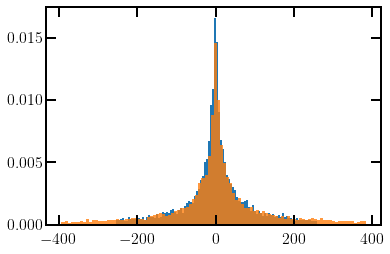

In [818]:
def histo(data, alpha=1.0, color=None):
    a, b = np.histogram(
        data, bins=100, density=True,
        range = (np.quantile(data, .1), np.quantile(data, .9)),
    )
    x = (b[1:] + b[:-1])/2
    b_width = np.diff(b)[0]
    if color is None:
        plt.bar(x, a, b_width, alpha=alpha)
    else:
        plt.bar(x, a, b_width, alpha=alpha, color=color)
    
plt.figure()
# plt.xlim(-.1,.1)

histo(Tset[:,-1,0])
histo(Tset[:,-1,1], alpha=0.8)

# histo(Tset[:5000,-1,0])
# histo(Tset[:5000,-1,1], alpha=1.0)

# histo(Tset[5000:,-1,0], alpha=0.6)
# histo(Tset[5000:,-1,1], alpha=0.6)

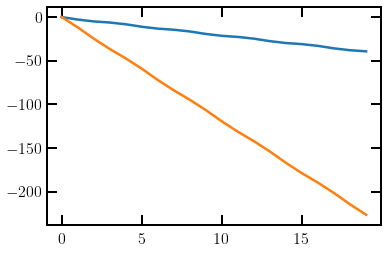

In [817]:
plt.figure()
ind = 50
plt.plot(np.arange(20), Tset[ind][:,0])
plt.plot(np.arange(20), Tset[ind][:,1])

little wiggles are probably machine precision.  We're looking at micro-arcsecond deflections, meaning 5e-12 deflections.  Somehow we lose an extra 4 orders of magnitude and start running into machine precision problems.

N_0 = 20 fixed, N_t allowed to float

- With units, 1e2 iterations takes about 6.6s.
- Without, 1e3 iterations takes 2.2s (Also stopped using np.linalg.norm function)
- Using Observer.observe on (Sources, Lenses) rather than (Source, Lens), 1e4 iterations takes 2.9s
- Generating lenses and sources using new standard option, 1e5 takes 0.6s

# Generate Multi-Blip Training Data

In [67]:
# Made a histogram of Gaia stars, converted to cdf, inverted it
# x-axis scale is parsec, so we convert
inv_cdf_raw = pickle.load(open('/Users/gregoryridgway/Desktop/AstroML/'+
                          'Astrometric_TSeries_ML/data/Gaia_DR2_inv_cdf', 'rb'))

def inv_cdf(p):
    return inv_cdf_raw(p) * 1e-3  # converts to kpc

In [74]:
%autoreload
lenses, sources = lt.sample('standard', int(N_t), scale,
                            inv_cdf, obs, kind, M_l, R_l)
# data = obs.observe(sources)

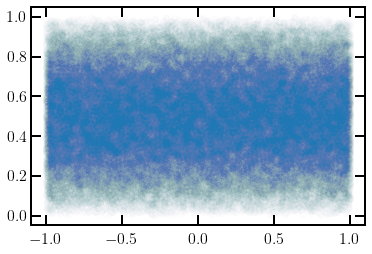

In [78]:
data = obs.observe(sources)
plt.figure()
plt.scatter(data[:,1]/pi, data[:,0]/pi, alpha=0.008)

In [79]:
lenses, sources = lt.sample('standard', int(N_t/5), scale,
                            inv_cdf, obs, kind, M_l, R_l, N_spl=5)

What's the source density?  That should tell us sources per lens (N_spl)

How do we make the training set? 
- Make a full sky set of lenses and sources, then make groups of N_g (say 5) sources